## DDoS Defense: A Multiclass and Multidimensional Detection System with Diverse Machine Learning Models
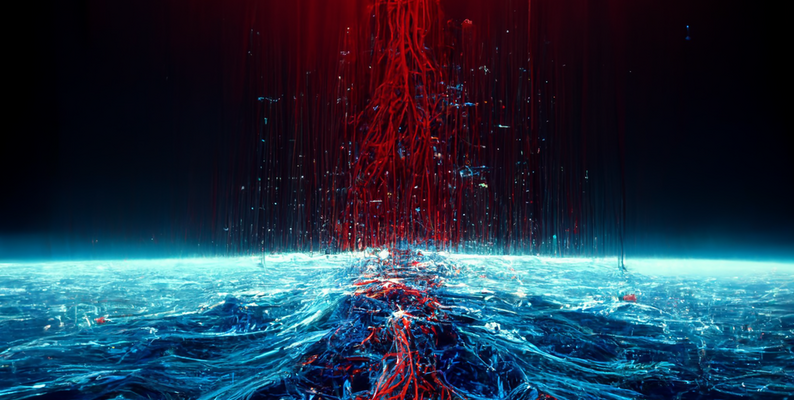
### Project Overview

This project is focused on building a system to detect and classify **DDoS (Distributed Denial of Service)** attacks using the **CICDDoS2019** dataset. The goal is to develop a multiclass classification model that can identify various DDoS attacks from normal network traffic. The dataset consists of multiple attack types with different network traffic characteristics, making it a challenging problem for DDoS detection.

### Dataset Description

The **CICDDoS2019** dataset, provided by the Canadian Institute for Cybersecurity (CIC), contains network traffic data representing several types of DDoS attacks along with benign (non-attack) traffic. The dataset features several attributes like packet size, source/destination IPs, and protocol types. The target variable consists of different attack labels as follows:

- **Syn**: SYN flood attack
- **Benign**: Normal, non-attack traffic
- **Portmap**: Portmapper-based DDoS attack
- **UDP**: Generic UDP flood attack
- **UDPLag**: UDP-based DDoS with lag
- **MSSQL**: MSSQL-specific DDoS attack
- **NetBIOS**: NetBIOS-related DDoS attack
- **LDAP**: Lightweight Directory Access Protocol-based attack

### Process Overview

#### Data Collection and Preprocessing
1. **Collecting Data Paths**:
   - The paths of training and testing datasets are collected using a file walk through. 
   - We ensure that only the datasets with matching names are used for training and testing.

2. **Data Processing**:
   - **Column Mapping**: We map the column names between the training and testing datasets, ensuring they are consistent. The column names in the testing set are renamed to match the training set.
   - **Null and Duplicate Handling**: We check for any null or duplicate values. No null values are found, and any duplicates in the dataset are removed.
   - **Removing Single Unique Value Columns**: Columns with only a single unique value are dropped as they do not provide meaningful information for classification.
   - **Removing Highly Correlated Columns**: Columns with a correlation coefficient of 0.8 or higher are dropped to reduce multicollinearity and improve model performance.

#### Exploratory Data Analysis (EDA)
Several key visualizations were performed to understand the dataset:

- **Distribution of Categorical Columns**: 
   - Frequency distribution using bar plots and percentage distribution using pie charts for categorical features.
- **Flow Duration Distribution**: 
   - Analyzing the flow duration distribution for both DDoS and normal traffic.
- **Packet Length Mean by Protocol and Attack Label**: 
   - Exploring the average packet length by protocol type and attack label.
- **Flags Distribution by Attack Label**: 
   - Distribution of different flag types across attack labels.
- **Protocol Requests Distribution**: 
   - Number of requests coming from different protocols.
- **Correlation Matrix**: 
   - A heatmap to visualize the correlation matrix and identify relationships between features.

#### Data Preprocessing and Feature Engineering
- **Train-Test Split**: 
   - The dataset is split into training, validation, and test sets to ensure proper evaluation of the model.
- **Feature Encoding**: 
   - The target column is encoded using **LabelEncoder** to convert categorical labels into numerical values for training.
- **Feature Scaling**: 
   - We apply **Min-Max Scaling** to scale the features to a uniform range, improving the performance of distance-based algorithms.

#### Model Training and Evaluation
- **Model Selection**: 
   - Several models are trained and evaluated for multiclass classification, including:
     - **Tranfomer**
     - **Convolutional Neural Network (CNN)**
     - **Long Short-Term Memory (LSTM)**
   
- **Model Evaluation**:
   - We evaluate the models using various performance metrics like **accuracy**, **precision**, **recall**, **F1-score**, and **ROC AUC**.
   - ROC curves are plotted to compare the performance of each model across different classes.
   - A table of the model scores is created and displayed for easy comparison.

#### Results Visualization
- **Model Comparison**: 
   - We plot the **accuracy score** for each model to visually compare their performance.
   - ROC curves for all models are plotted to analyze their classification ability, especially for multiclass classification tasks.


## Import Libraries

In [1]:
import os
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
from copy import deepcopy


from sklearn.inspection import permutation_importance
from sklearn.metrics import recall_score, classification_report
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, f1_score, roc_curve
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# Removed SMOTE import
from scipy import stats  # For statistical tests
from scipy.stats import f_oneway


import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Conv1D, MaxPooling1D, Flatten, LSTM, Input, MultiHeadAttention
from tensorflow.keras.layers import LayerNormalization, GlobalAveragePooling1D, Embedding
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Add
from tensorflow.keras.optimizers import Adam
from collections import Counter

import pickle

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Collecting Training and Testing Dataset File Paths
dfps_train = []
dfps_test = []

for dirname, _, filenames in os.walk('/kaggle/input/cicddos2019/'):
    for filename in filenames:
        if filename.endswith('-training.parquet'):
            dfp = os.path.join(dirname, filename)
            dfps_train.append(dfp)
            print(dfp)
        elif filename.endswith('-testing.parquet'):
            dfp = os.path.join(dirname, filename)
            dfps_test.append(dfp)
            print(dfp)

/kaggle/input/cicddos2019/Syn-training.parquet
/kaggle/input/cicddos2019/UDPLag-testing.parquet
/kaggle/input/cicddos2019/NetBIOS-testing.parquet
/kaggle/input/cicddos2019/Portmap-training.parquet
/kaggle/input/cicddos2019/Syn-testing.parquet
/kaggle/input/cicddos2019/MSSQL-testing.parquet
/kaggle/input/cicddos2019/SNMP-testing.parquet
/kaggle/input/cicddos2019/UDPLag-training.parquet
/kaggle/input/cicddos2019/NTP-testing.parquet
/kaggle/input/cicddos2019/LDAP-testing.parquet
/kaggle/input/cicddos2019/UDP-training.parquet
/kaggle/input/cicddos2019/NetBIOS-training.parquet
/kaggle/input/cicddos2019/DNS-testing.parquet
/kaggle/input/cicddos2019/UDP-testing.parquet
/kaggle/input/cicddos2019/LDAP-training.parquet
/kaggle/input/cicddos2019/TFTP-testing.parquet
/kaggle/input/cicddos2019/MSSQL-training.parquet


In [3]:
# Common Prefixes in both lists
train_prefixes = [dfp.split('/')[-1].split('-')[0] for dfp in dfps_train]
test_prefixes = [dfp.split('/')[-1].split('-')[0] for dfp in dfps_test]

common_prefixes = list(set(train_prefixes).intersection(test_prefixes))

# Filter the dataframes to only include the common prefixes
dfps_train = [dfp for dfp in dfps_train if dfp.split('/')[-1].split('-')[0] in common_prefixes]
dfps_test = [dfp for dfp in dfps_test if dfp.split('/')[-1].split('-')[0] in common_prefixes]
print("✅ dfps_train:", dfps_train)
print("✅ dfps_test:", dfps_test)
print("✅ common_prefixes:", common_prefixes)

✅ dfps_train: ['/kaggle/input/cicddos2019/Syn-training.parquet', '/kaggle/input/cicddos2019/UDPLag-training.parquet', '/kaggle/input/cicddos2019/UDP-training.parquet', '/kaggle/input/cicddos2019/NetBIOS-training.parquet', '/kaggle/input/cicddos2019/LDAP-training.parquet', '/kaggle/input/cicddos2019/MSSQL-training.parquet']
✅ dfps_test: ['/kaggle/input/cicddos2019/UDPLag-testing.parquet', '/kaggle/input/cicddos2019/NetBIOS-testing.parquet', '/kaggle/input/cicddos2019/Syn-testing.parquet', '/kaggle/input/cicddos2019/MSSQL-testing.parquet', '/kaggle/input/cicddos2019/LDAP-testing.parquet', '/kaggle/input/cicddos2019/UDP-testing.parquet']
✅ common_prefixes: ['LDAP', 'Syn', 'UDP', 'NetBIOS', 'MSSQL', 'UDPLag']


In [4]:
train_df = pd.concat([pd.read_parquet(dfp) for dfp in dfps_train], ignore_index=True)
test_df = pd.concat([pd.read_parquet(dfp) for dfp in dfps_test], ignore_index=True)

In [5]:
print(train_df.shape, test_df.shape)

(120065, 78) (38973, 78)


In [6]:
# Thư mục chứa các file .parquet
data_dir = '/kaggle/input/cicids2017/'  # Cập nhật lại đúng đường dẫn thư mục

try:
    all_dfs = []

    for file in os.listdir(data_dir):
        if file.endswith('.parquet'):
            file_path = os.path.join(data_dir, file)

            # Đọc file parquet
            df = pd.read_parquet(file_path)

            # Tạo nhãn từ tên file (lấy phần trước dấu '-' làm nhãn)
            label = file.split('-')[0]
            df['Label'] = label

            all_dfs.append(df)

    # Gộp tất cả các dataframe lại
    cicddos2017_df = pd.concat(all_dfs, ignore_index=True)
    has_2017_data = True
    print(f"✅ Loaded CICDDoS2017 data: {cicddos2017_df.shape}")
    print(f"📊 Nhãn (labels) duy nhất: {cicddos2017_df['Label'].unique()}")
except Exception as e:
    has_2017_data = False
    print(f"❌ Could not load CICDDoS2017 data: {e}")

✅ Loaded CICDDoS2017 data: (2313810, 78)
📊 Nhãn (labels) duy nhất: ['Benign' 'Bruteforce' 'Portscan' 'WebAttacks' 'DoS' 'DDoS' 'Infiltration'
 'Botnet']


In [7]:
label_mapping = {
    'DrDoS_UDP': 'UDP',
    'UDP-lag': 'UDPLag',
    'DrDoS_MSSQL': 'MSSQL',
    'DrDoS_LDAP': 'LDAP',
    'DrDoS_NetBIOS': 'NetBIOS',
    'Syn': 'Syn',  # Already matches
    'Benign': 'Benign'  # Already matches
}

# Apply mapping to test_df
test_df["Label"] = test_df["Label"].map(label_mapping)


In [8]:
# Drop the WebDDoS class from the testing data
test_df = test_df[test_df["Label"] != "WebDDoS"]

In [9]:
# Check the target distribution of the testing data after mapping
print(test_df["Label"].value_counts())

Label
Benign     10847
UDP        10420
UDPLag      8872
MSSQL       6212
LDAP        1440
NetBIOS      598
Syn          533
Name: count, dtype: int64


In [10]:
# Xử lý NaN nếu có
train_df = train_df.dropna(subset=["Label"])
test_df = test_df.dropna(subset=["Label"])

# Lọc nhãn chưa thấy trong train
known_labels = set(train_df["Label"].unique())
test_df = test_df[test_df["Label"].isin(known_labels)]

In [11]:
# Encode the labels
le = LabelEncoder()
train_df["Label"] = le.fit_transform(train_df["Label"])
test_df["Label"] = le.transform(test_df["Label"])

In [12]:
# Function to identify columns by type
def grab_col_names(data, cat_th=10, car_th=20):
    # Categorical columns and categorical but high-cardinality columns
    cat_cols = [col for col in data.columns if data[col].dtypes == "O"]
    num_but_cat = [col for col in data.columns if data[col].nunique() < cat_th and data[col].dtypes != "O"]
    high_card_cat_cols = [col for col in data.columns if data[col].nunique() > car_th and data[col].dtypes == "O"]

    # Combine Object type columns and Low-unique-value numeric columns into cat_cols
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in high_card_cat_cols]

    # Numerical columns excluding those considered as categorical
    num_cols = [col for col in data.columns if data[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    # Display information about the dataset
    print(f"Observations: {data.shape[0]}")
    print(f"Variables: {data.shape[1]}")
    print(f"Categorical Columns: {len(cat_cols)}")
    print(f"Numerical Columns: {len(num_cols)}")
    print(f"High Cardinality Categorical Columns: {len(high_card_cat_cols)}")
    print(f"Number but Categorical Columns: {len(num_but_cat)}")
    print("\n")

    return cat_cols, num_cols, high_card_cat_cols

cat_cols, num_cols, high_card_cat_cols = grab_col_names(train_df)

Observations: 120065
Variables: 78
Categorical Columns: 20
Numerical Columns: 58
High Cardinality Categorical Columns: 0
Number but Categorical Columns: 20




In [13]:
# Tính số lượng giá trị duy nhất cho từng cột trong train_df
nunique_series = train_df.nunique()

# Lọc các cột chỉ có duy nhất 1 giá trị
single_val_cols = nunique_series[nunique_series == 1].index.tolist()

# In ra danh sách các cột đó
print("Columns with single unique value:", single_val_cols)

# Loại bỏ các cột đó khỏi cả train_df và test_df
train_df.drop(columns=single_val_cols, inplace=True)
test_df.drop(columns=single_val_cols, inplace=True)

# In hình dạng của dataframe sau khi xoá cột
print("Dataset shape after removing single value columns:", train_df.shape, test_df.shape)


Columns with single unique value: ['Bwd PSH Flags', 'Fwd URG Flags', 'Bwd URG Flags', 'FIN Flag Count', 'PSH Flag Count', 'ECE Flag Count', 'Fwd Avg Bytes/Bulk', 'Fwd Avg Packets/Bulk', 'Fwd Avg Bulk Rate', 'Bwd Avg Bytes/Bulk', 'Bwd Avg Packets/Bulk', 'Bwd Avg Bulk Rate']
Dataset shape after removing single value columns: (120065, 66) (38922, 66)


In [14]:
# Function to find and remove highly correlated features with different thresholds
def remove_highly_correlated_features(df, threshold=0.8):
    # Select only numeric columns
    numerical_df = df.select_dtypes(include=[np.number])
    
    # Calculate the correlation matrix
    corr_matrix = numerical_df.corr().abs()
    
    # Generate a boolean mask for the upper triangle
    mask = np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)
    
    # Select the upper triangle of the correlation matrix
    upper_triangle = corr_matrix.where(mask)
    
    # Find the columns with correlation higher than threshold
    high_corr_cols = [col for col in upper_triangle.columns if any(upper_triangle[col] > threshold)]
    
    # Display the number of highly correlated columns and their names
    print(f"Total number of highly correlated columns (threshold={threshold}): {len(high_corr_cols)}")
    print("Highly correlated columns are:", high_corr_cols)
    
    # Remove highly correlated columns from the dataframe
    df_filtered = df.drop(high_corr_cols, axis=1)
    
    return df_filtered, high_corr_cols

In [15]:
# Test different correlation thresholds (0.8, 0.85, 0.9)
correlation_thresholds = [0.8, 0.85, 0.9]
filtered_dfs = {}
high_corr_cols_dict = {}

for threshold in correlation_thresholds:
    print(f"\n--- Testing correlation threshold: {threshold} ---")
    filtered_df, high_corr_cols = remove_highly_correlated_features(train_df, threshold)
    filtered_dfs[threshold] = filtered_df
    high_corr_cols_dict[threshold] = high_corr_cols
    print(f"Dataset shape after removing highly correlated columns: {filtered_df.shape}")



--- Testing correlation threshold: 0.8 ---
Total number of highly correlated columns (threshold=0.8): 33
Highly correlated columns are: ['Bwd Packets Length Total', 'Fwd Packet Length Mean', 'Bwd Packet Length Mean', 'Bwd Packet Length Std', 'Flow IAT Std', 'Flow IAT Max', 'Fwd IAT Total', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max', 'Fwd IAT Min', 'Bwd IAT Std', 'Bwd IAT Max', 'Fwd Packets/s', 'Packet Length Min', 'Packet Length Max', 'Packet Length Mean', 'Packet Length Std', 'Packet Length Variance', 'RST Flag Count', 'Avg Packet Size', 'Avg Fwd Segment Size', 'Avg Bwd Segment Size', 'Subflow Fwd Packets', 'Subflow Fwd Bytes', 'Subflow Bwd Packets', 'Subflow Bwd Bytes', 'Fwd Seg Size Min', 'Active Max', 'Active Min', 'Idle Mean', 'Idle Max', 'Idle Min']
Dataset shape after removing highly correlated columns: (120065, 33)

--- Testing correlation threshold: 0.85 ---
Total number of highly correlated columns (threshold=0.85): 33
Highly correlated columns are: ['Bwd Packets Length To

In [16]:
# Split the data for each threshold
X_train_dict = {}
X_val_dict = {}
y_train_dict = {}
y_val_dict = {}

for threshold in correlation_thresholds:
    filtered_df = filtered_dfs[threshold]
    X_train, X_val, y_train, y_val = train_test_split(
        filtered_df.drop("Label", axis=1),
        filtered_df["Label"],
        test_size=0.2,
        random_state=42,
        stratify=filtered_df["Label"]
    )
    
    X_train_dict[threshold] = X_train
    X_val_dict[threshold] = X_val
    y_train_dict[threshold] = y_train
    y_val_dict[threshold] = y_val

In [17]:
# Apply same transformations to test data for each threshold
X_test_dict = {}
y_test = test_df["Label"]

for threshold in correlation_thresholds:
    high_corr_cols = high_corr_cols_dict[threshold]
    # Make sure test data has the same columns as train data
    X_test_dict[threshold] = test_df.drop(["Label"] + high_corr_cols, axis=1)

In [18]:
# Display class distributions
for threshold in correlation_thresholds:
    print(f"\n--- Class distribution for threshold {threshold} ---")
    print("Train set:", Counter(y_train_dict[threshold]))
    print("Validation set:", Counter(y_val_dict[threshold]))
    print("Test set:", Counter(y_test))


--- Class distribution for threshold 0.8 ---
Train set: Counter({4: 39072, 0: 33606, 5: 14472, 2: 6818, 1: 1525, 3: 515, 6: 44})
Validation set: Counter({4: 9768, 0: 8401, 5: 3618, 2: 1705, 1: 381, 3: 129, 6: 11})
Test set: Counter({0: 10847, 5: 10420, 6: 8872, 2: 6212, 1: 1440, 3: 598, 4: 533})

--- Class distribution for threshold 0.85 ---
Train set: Counter({4: 39072, 0: 33606, 5: 14472, 2: 6818, 1: 1525, 3: 515, 6: 44})
Validation set: Counter({4: 9768, 0: 8401, 5: 3618, 2: 1705, 1: 381, 3: 129, 6: 11})
Test set: Counter({0: 10847, 5: 10420, 6: 8872, 2: 6212, 1: 1440, 3: 598, 4: 533})

--- Class distribution for threshold 0.9 ---
Train set: Counter({4: 39072, 0: 33606, 5: 14472, 2: 6818, 1: 1525, 3: 515, 6: 44})
Validation set: Counter({4: 9768, 0: 8401, 5: 3618, 2: 1705, 1: 381, 3: 129, 6: 11})
Test set: Counter({0: 10847, 5: 10420, 6: 8872, 2: 6212, 1: 1440, 3: 598, 4: 533})


In [19]:
# Label mapping for the target variable
label_map = {index: Label for index, Label in enumerate(le.classes_)}
print("Label mapping:", label_map)

Label mapping: {0: 'Benign', 1: 'LDAP', 2: 'MSSQL', 3: 'NetBIOS', 4: 'Syn', 5: 'UDP', 6: 'UDPLag'}


In [20]:
#Feature Scaling for each threshold
scaler_dict = {}
X_train_scaled_dict = {}
X_val_scaled_dict = {}
X_test_scaled_dict = {}
for threshold in correlation_thresholds:
    scaler = MinMaxScaler()
    X_train_scaled_dict[threshold] = scaler.fit_transform(X_train_dict[threshold])
    X_val_scaled_dict[threshold] = scaler.transform(X_val_dict[threshold])
    X_test_scaled_dict[threshold] = scaler.transform(X_test_dict[threshold])
    scaler_dict[threshold] = scaler

In [21]:
# Convert target to one-hot encoding for neural networks
num_classes = len(le.classes_)
y_train_cat_dict = {}
y_val_cat_dict = {}
y_test_cat = to_categorical(y_test)

for threshold in correlation_thresholds:
    y_train_cat_dict[threshold] = to_categorical(y_train_dict[threshold])
    y_val_cat_dict[threshold] = to_categorical(y_val_dict[threshold])


In [22]:
# Reshape data for CNN and LSTM 
X_train_reshaped_dict = {}
X_val_reshaped_dict = {}
X_test_reshaped_dict = {}

for threshold in correlation_thresholds:
    X_train_reshaped_dict[threshold] = X_train_scaled_dict[threshold].reshape(
        X_train_scaled_dict[threshold].shape[0], X_train_scaled_dict[threshold].shape[1], 1)
    X_val_reshaped_dict[threshold] = X_val_scaled_dict[threshold].reshape(
        X_val_scaled_dict[threshold].shape[0], X_val_scaled_dict[threshold].shape[1], 1)
    X_test_reshaped_dict[threshold] = X_test_scaled_dict[threshold].reshape(
        X_test_scaled_dict[threshold].shape[0], X_test_scaled_dict[threshold].shape[1], 1)

In [23]:
# Model definitions
def create_cnn_model(input_shape, num_classes):
    model = Sequential([
        Conv1D(64, 3, activation='relu', padding='same', input_shape=input_shape),
        MaxPooling1D(2),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.3),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

def create_lstm_model(input_shape, num_classes):
    model = Sequential([
        LSTM(64, return_sequences=True, input_shape=input_shape),
        LSTM(128),
        Dense(64, activation='relu'),
        Dropout(0.3),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

def get_positional_encoding(input_dim, output_dim):
    position = np.arange(input_dim)[:, np.newaxis]
    div_term = np.exp(np.arange(0, output_dim, 2) * -(np.log(10000.0) / output_dim))
    pe = np.zeros((input_dim, output_dim))
    pe[:, 0::2] = np.sin(position * div_term)
    pe[:, 1::2] = np.cos(position * div_term)
    pe = pe[np.newaxis, ...]  # Shape: (1, input_dim, output_dim)
    return tf.constant(pe, dtype=tf.float32)

def create_transformer_model(input_shape, num_classes):
    input_layer = Input(shape=input_shape)  # (seq_len, feature_dim)
    x = Dense(128, activation='relu')(input_layer)

    # Positional encoding
    positional_encoding = get_positional_encoding(input_shape[0], 128)
    x = Add()([x, positional_encoding])  # Broadcasting ok

    # Multi-head attention
    att = MultiHeadAttention(num_heads=4, key_dim=32)(x, x)
    x = Add()([x, att])
    x = LayerNormalization()(x)
    x = Dropout(0.4)(x)

    # Feed-forward Network (FFN)
    ffn = Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
    ffn = Dropout(0.4)(ffn)
    x = Add()([x, ffn])
    x = LayerNormalization()(x)

    # Output
    x = GlobalAveragePooling1D()(x)
    x = Dropout(0.4)(x)
    output_layer = Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model
def save_training_artifacts(train_df, test_df, model=None, save_dir=r"C:\Users\Podo\Downloads\DACS\data"):
    """
    Save training data and model to the specified directory.
    """
    os.makedirs(save_dir, exist_ok=True)

    train_path = os.path.join(save_dir, "train_data.parquet")
    test_path = os.path.join(save_dir, "test_data.parquet")
    model_path = os.path.join(save_dir, "trained_model.keras")

    if not os.path.exists(train_path):
        train_df.to_parquet(train_path, index=False)
        print(f"✅ Train data saved to: {train_path}")
    else:
        print(f"🔁 Train data already exists at: {train_path}")

    if not os.path.exists(test_path):
        test_df.to_parquet(test_path, index=False)
        print(f"✅ Test data saved to: {test_path}")
    else:
        print(f"🔁 Test data already exists at: {test_path}")

    if model:
        model.save(model_path)
        print(f"✅ Model saved to: {model_path}")

In [24]:
def evaluate_model(model, X_test, y_test, y_test_cat, model_name):
    """
    Evaluate the deep learning model:
      - Calculate accuracy, precision, recall (weighted), F1, ROC AUC
      - Calculate recall for each class
      - Plot confusion matrix
      - Print recall for each class
    """
    # Predict probabilities for test set
    y_pred_prob = model.predict(X_test)            
    y_pred = np.argmax(y_pred_prob, axis=1)   

    # Calculate general metrics (for multiclass as weighted)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(
        y_test, y_pred,
        average='weighted', zero_division=0
    )
    recall_weighted = recall_score(
        y_test, y_pred,
        average='weighted', zero_division=0
    )
    f1 = f1_score(
        y_test, y_pred,
        average='weighted'
    )

    # Calculate ROC AUC
    if y_test_cat.shape[1] > 2:
        roc_auc = roc_auc_score(
            y_test_cat, y_pred_prob,
            multi_class='ovr', average='weighted'
        )
    else:
        roc_auc = roc_auc_score(
            y_test_cat, y_pred_prob[:, 1]
        )

    # Calculate recall for each class
    recall_per_class = recall_score(
        y_test, y_pred,
        average=None, zero_division=0
    )

    # Plot confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    class_names = [label_map[i] for i in range(len(label_map))]
    plt.figure(figsize=(10, 8))
    sns.heatmap(
        cm, annot=True, fmt='d', cmap='Blues',
        xticklabels=class_names, yticklabels=class_names
    )
    plt.title(f'Confusion Matrix - {model_name}')
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.xticks(rotation=45)
    plt.yticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # Print recall for each class
    print(f"\nRecall for each class ({model_name}):")
    for i, label in label_map.items():
        print(f"  {label}: {recall_per_class[i]:.4f}")

    # Return general metrics as dict
    return {
        "Model": model_name,
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall (weighted)": recall_weighted,
        "F1 Score": f1,
        "ROC AUC": roc_auc
    }

In [25]:
def train_with_kfold(X, y, model_creator, input_shape, num_classes, n_folds=5, epochs=20, batch_size=64):
    from sklearn.model_selection import KFold
    from tensorflow.keras.utils import to_categorical

    kfold = KFold(n_splits=n_folds, shuffle=True, random_state=42)
    all_scores = []

    for fold, (train_idx, val_idx) in enumerate(kfold.split(X)):
        print(f"\nFold {fold + 1}/{n_folds}")
        X_train_fold, X_val_fold = X[train_idx], X[val_idx]
        y_train_fold, y_val_fold = y.iloc[train_idx], y.iloc[val_idx]

        y_train_cat = to_categorical(y_train_fold, num_classes=num_classes)
        y_val_cat = to_categorical(y_val_fold, num_classes=num_classes)

        model = model_creator(input_shape=input_shape, num_classes=num_classes)
        model.fit(X_train_fold, y_train_cat, validation_data=(X_val_fold, y_val_cat),
                  epochs=epochs, batch_size=batch_size, verbose=0)

        score = model.evaluate(X_val_fold, y_val_cat, verbose=0)
        print(f"Validation Loss: {score[0]:.4f} - Accuracy: {score[1]:.4f}")
        all_scores.append(score[1])

    avg_accuracy = sum(all_scores) / len(all_scores)

    # ✅ Trả về dict thay vì chỉ float
    return {
    "Accuracy": avg_accuracy,
    "Std Accuracy": np.std(all_scores)
    }


In [26]:
def run_kfold_experiments(correlation_thresholds, X_train_reshaped_dict, y_train_dict, n_folds=5, epochs=20, batch_size=64):
    results = {}

    for threshold in correlation_thresholds:
        print(f"\n--- Running K-fold validation for threshold {threshold} ---")
        X_data = X_train_reshaped_dict[threshold]
        y_data = y_train_dict[threshold]

        # Ensure y_data is one-hot encoded
        if len(y_data.shape) == 1:
            y_data = to_categorical(y_data)

        num_classes = y_data.shape[1]

        # Define models dynamically with correct input shape and number of classes
        models = {
            'CNN': lambda: create_cnn_model(X_data.shape[1:], num_classes),
            'LSTM': lambda: create_lstm_model(X_data.shape[1:], num_classes),
            'Transformer': lambda: create_transformer_model(X_data.shape[1:], num_classes)
        }

        for model_name, model_fn in models.items():
            print(f"\nRunning K-fold for {model_name} with threshold {threshold}")
            accuracies, precisions, recalls, f1_scores = [], [], [], []

            kfold = KFold(n_splits=n_folds, shuffle=True, random_state=42)
            fold = 1

            for train_index, val_index in kfold.split(X_data):
                print(f"\nFold {fold}/{n_folds}")
                fold += 1

                X_train_fold, X_val_fold = X_data[train_index], X_data[val_index]
                y_train_fold, y_val_fold = y_data[train_index], y_data[val_index]

                model = model_fn()  # Create new instance for each fold
                model.fit(X_train_fold, y_train_fold, epochs=epochs, batch_size=batch_size, verbose=0)

                y_pred = model.predict(X_val_fold)
                y_pred_classes = np.argmax(y_pred, axis=1)
                y_true = np.argmax(y_val_fold, axis=1)

                accuracies.append(accuracy_score(y_true, y_pred_classes))
                precisions.append(precision_score(y_true, y_pred_classes, average='weighted', zero_division=0))
                recalls.append(recall_score(y_true, y_pred_classes, average='weighted', zero_division=0))
                f1_scores.append(f1_score(y_true, y_pred_classes, average='weighted', zero_division=0))

            avg_metrics = {
                'Accuracy': np.mean(accuracies),
                'Std Accuracy': np.std(accuracies),
                'Precision': np.mean(precisions),
                'Std Precision': np.std(precisions),
                'Recall': np.mean(recalls),
                'Std Recall': np.std(recalls),
                'F1 Score': np.mean(f1_scores),
                'Std F1 Score': np.std(f1_scores)
            }

            print(f"Average metrics for {model_name} with threshold {threshold}:")
            print(f"  Accuracy: {avg_metrics['Accuracy']:.4f} (±{avg_metrics['Std Accuracy']:.4f})")
            print(f"  Precision: {avg_metrics['Precision']:.4f} (±{avg_metrics['Std Precision']:.4f})")
            print(f"  Recall: {avg_metrics['Recall']:.4f} (±{avg_metrics['Std Recall']:.4f})")
            print(f"  F1 Score: {avg_metrics['F1 Score']:.4f} (±{avg_metrics['Std F1 Score']:.4f})")

            results[(threshold, model_name)] = avg_metrics

    return results

In [27]:
# Train models on the best threshold
def train_deep_models(X_train, X_val, y_train_cat, y_val_cat, train_df, test_df, epochs=10, batch_size=64):
    scores_list = []
    history_dict = {}
    trained_models = {}

    early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    models = {
        "CNN": create_cnn_model(X_train.shape[1:], y_train_cat.shape[1]),
        "LSTM": create_lstm_model(X_train.shape[1:], y_train_cat.shape[1]),
        "Transformer": create_transformer_model(X_train.shape[1:], y_train_cat.shape[1]),
    }

    print("🚀 Training Deep Learning Models:")

    for name, model in tqdm(models.items(), desc="Training Models", ncols=100):
        print(f"\n🔁 Training {name}...")
        history = model.fit(
            X_train, y_train_cat,
            epochs=epochs,
            batch_size=batch_size,
            validation_data=(X_val, y_val_cat),
            callbacks=[early_stop],
            verbose=0
        )

        # Save data & model
        save_dir = fr"E:\Project\DACS\data\{name.lower()}"
        save_training_artifacts(train_df, test_df, model, save_dir=save_dir)

        history_dict[name] = history
        trained_models[name] = model
        scores_list.append(
            evaluate_model(model, X_val, np.argmax(y_val_cat, axis=1), y_val_cat, name)
        )

    return scores_list, history_dict, trained_models


In [28]:
def perform_statistical_test(kfold_results):
    model_groups = {}

    for (threshold, model_name), metrics in kfold_results.items():
        if model_name not in model_groups:
            model_groups[model_name] = []
        model_groups[model_name].append(metrics['Accuracy'])  # Bạn cũng có thể thay bằng F1 Score

    print("\nANOVA Test on Accuracy Scores:")
    for model, scores in model_groups.items():
        print(f"{model}: {scores}")

    # Kiểm tra số lượng nhóm đủ để thực hiện ANOVA
    if len(model_groups) >= 2:
        f_stat, p_value = f_oneway(*model_groups.values())
        print(f"\nF-statistic: {f_stat:.4f}, P-value: {p_value:.4f}")
        if p_value < 0.05:
            print("Kết luận: Có sự khác biệt đáng kể giữa các mô hình.")
        else:
            print("Kết luận: Không có sự khác biệt đáng kể giữa các mô hình.")
    else:
        print("Không đủ mô hình để thực hiện kiểm định thống kê.")

In [29]:
def cross_dataset_evaluation(trained_models, cicddos2017_df):
    if not has_2017_data:
        print("❌ Cannot perform cross-dataset evaluation: no 2017 data available")
        return
    
    print("\n--- Cross-Dataset Evaluation (2019 → 2017) ---")
    
    # Prepare 2017 data
    # Assuming the 2017 dataset has similar structure to the 2019 dataset
    X_2017 = cicddos2017_df.drop("Label", axis=1)
    y_2017 = cicddos2017_df["Label"]
    
    # Encode the labels (use the same encoder as for 2019 data)
    try:
        y_2017 = le.transform(y_2017)
        y_2017_cat = to_categorical(y_2017)
        
        # Scale the features using the same scaler as for 2019 data
        # Use the scaler from the best threshold
        best_threshold = 0.85  # You may want to determine this dynamically
        X_2017_scaled = scaler_dict[best_threshold].transform(X_2017)
        X_2017_reshaped = X_2017_scaled.reshape(X_2017_scaled.shape[0], X_2017_scaled.shape[1], 1)
        
        # Evaluate each model on 2017 data
        cross_eval_results = []
        for model_name, model in trained_models.items():
            print(f"\nEvaluating {model_name} on 2017 data...")
            result = evaluate_model(model, X_2017_reshaped, y_2017, y_2017_cat, f"{model_name} (2017)")
            cross_eval_results.append(result)
        
# Display cross-evaluation results as a DataFrame
        cross_eval_df = pd.DataFrame(cross_eval_results)
        print("\nCross-dataset evaluation results:")
        print(cross_eval_df)
        
        return cross_eval_df
    except Exception as e:
        print(f"❌ Error during cross-dataset evaluation: {e}")
        return None

# Function to plot learning curves
def plot_learning_curves(history_dict):
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    for name, history in history_dict.items():
        # Plot accuracy
        axes[0].plot(history.history['accuracy'], label=f'{name} (train)')
        axes[0].plot(history.history['val_accuracy'], label=f'{name} (val)')
    
    axes[0].set_title('Model Accuracy')
    axes[0].set_ylabel('Accuracy')
    axes[0].set_xlabel('Epoch')
    axes[0].legend()
    axes[0].grid(True)
    
    for name, history in history_dict.items():
        # Plot loss
        axes[1].plot(history.history['loss'], label=f'{name} (train)')
        axes[1].plot(history.history['val_loss'], label=f'{name} (val)')
    
    axes[1].set_title('Model Loss')
    axes[1].set_ylabel('Loss')
    axes[1].set_xlabel('Epoch')
    axes[1].legend()
    axes[1].grid(True)
    
    plt.tight_layout()
    plt.show()



In [30]:
def visualize_feature_importance(model, X, feature_names, y_true, is_reshaped=False, n_repeats=5):
    # Nếu cần reshape
    if not is_reshaped:
        X = X.reshape(X.shape[0], X.shape[1], 1)

    baseline_preds = model.predict(X)
    baseline_preds = np.argmax(baseline_preds, axis=1)  # assuming classification
    baseline_score = accuracy_score(y_true, baseline_preds)

    importances = []
    
    for i in range(X.shape[1]):
        scores = []
        for _ in range(n_repeats):
            X_permuted = deepcopy(X)
            np.random.shuffle(X_permuted[:, i, 0])  # shuffle feature i
            permuted_preds = model.predict(X_permuted)
            permuted_preds = np.argmax(permuted_preds, axis=1)
            score = accuracy_score(y_true, permuted_preds)
            scores.append(baseline_score - score)
        importances.append(np.mean(scores))

    # Tạo DataFrame và vẽ
    df_importance = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    }).sort_values(by='Importance', ascending=False)

    plt.figure(figsize=(10, 8))
    sns.barplot(x='Importance', y='Feature', data=df_importance.head(20))
    plt.title('Permutation Feature Importance (Keras Model)')
    plt.tight_layout()
    plt.show()

    return df_importance

In [31]:
# Compare model performance
def compare_model_performance(scores_list):
    # Convert to DataFrame for easier comparison
    scores_df = pd.DataFrame(scores_list)
    scores_df = scores_df.set_index('Model')
    
    # Plot comparison
    plt.figure(figsize=(12, 8))
    scores_df[['Accuracy', 'Precision', 'Recall (weighted)', 'F1 Score', 'ROC AUC']].plot(
        kind='bar', colormap='viridis')
    plt.title('Model Performance Comparison')
    plt.ylabel('Score')
    plt.xticks(rotation=0)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.legend(loc='lower right')
    plt.tight_layout()
    plt.show()
    
    return scores_df

Starting the DDoS Detection Project...

--- Running K-fold Cross-Validation ---

--- Running K-fold validation for threshold 0.8 ---

Running K-fold for CNN with threshold 0.8

Fold 1/5
601/601 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

Fold 2/5
601/601 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step

Fold 3/5
601/601 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

Fold 4/5
601/601 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step

Fold 5/5
601/601 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Average metrics for CNN with threshold 0.8:
  Accuracy: 0.9865 (±0.0014)
  Precision: 0.9864 (±0.0016)
  Recall: 0.9865 (±0.0014)
  F1 Score: 0.9864 (±0.0015)

Running K-fold for LSTM with threshold 0.8

Fold 1/5
601/601 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step

Fold 2/5
601/601 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step

Fold 3/5
601/601 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step

Fold 4/5
601/601 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step

Fold 5/5
601/601 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
Average metrics for LSTM with threshold 0.8:
  Accuracy: 0.9817 (±0.0019)
  Precision: 0.9817 (±0.0020)
  Recal

Training Models:   0%|                                                        | 0/3 [00:00<?, ?it/s]


🔁 Training CNN...
✅ Train data saved to: E:\Project\DACS\data\cnn/train_data.parquet
✅ Test data saved to: E:\Project\DACS\data\cnn/test_data.parquet
✅ Model saved to: E:\Project\DACS\data\cnn/trained_model.keras
751/751 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


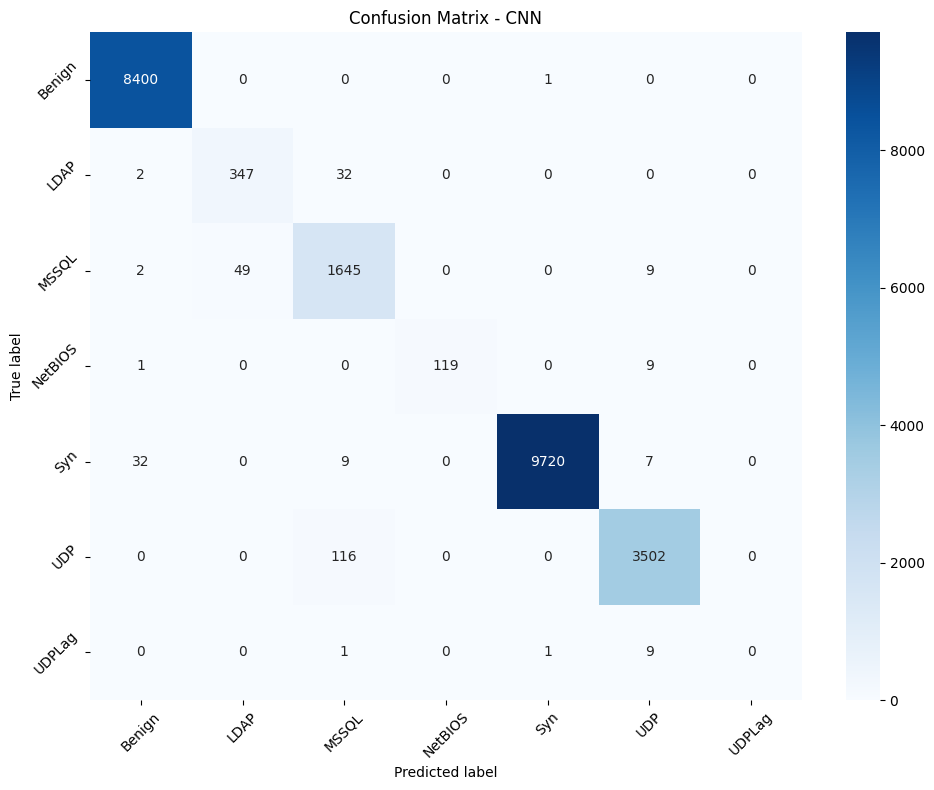

Training Models:  33%|████████████████                                | 1/3 [01:09<02:19, 69.80s/it]


Recall for each class (CNN):
  Benign: 0.9999
  LDAP: 0.9108
  MSSQL: 0.9648
  NetBIOS: 0.9225
  Syn: 0.9951
  UDP: 0.9679
  UDPLag: 0.0000

🔁 Training LSTM...
✅ Train data saved to: E:\Project\DACS\data\lstm/train_data.parquet
✅ Test data saved to: E:\Project\DACS\data\lstm/test_data.parquet
✅ Model saved to: E:\Project\DACS\data\lstm/trained_model.keras
751/751 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


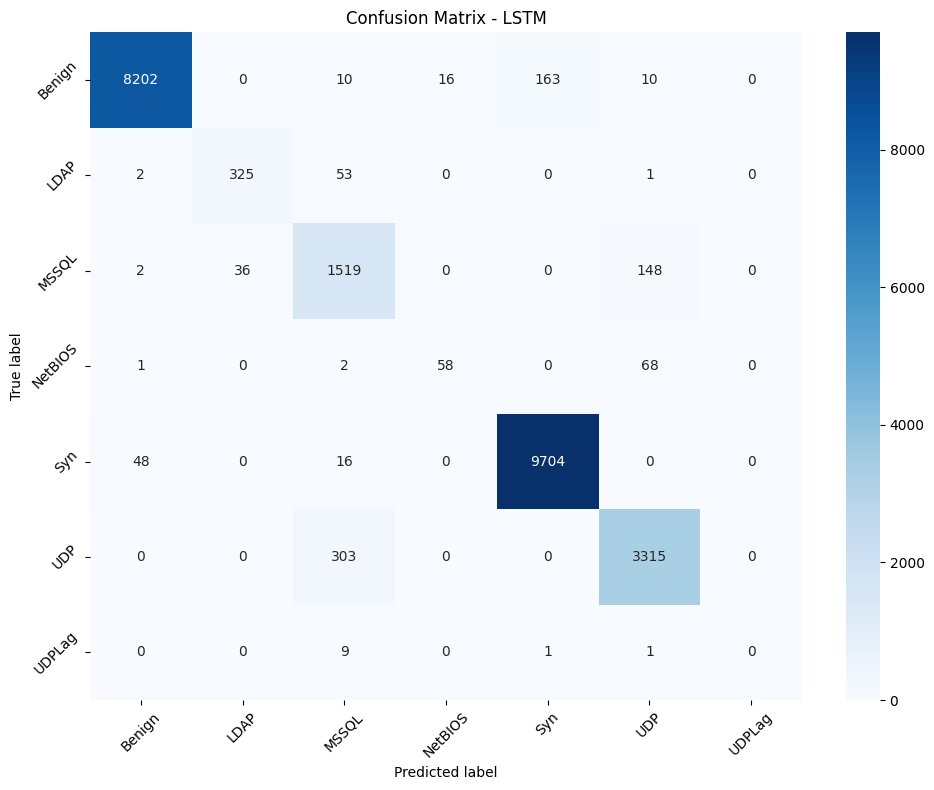

Training Models:  67%|████████████████████████████████                | 2/3 [02:06<01:02, 62.09s/it]


Recall for each class (LSTM):
  Benign: 0.9763
  LDAP: 0.8530
  MSSQL: 0.8909
  NetBIOS: 0.4496
  Syn: 0.9934
  UDP: 0.9163
  UDPLag: 0.0000

🔁 Training Transformer...
✅ Train data saved to: E:\Project\DACS\data\transformer/train_data.parquet
✅ Test data saved to: E:\Project\DACS\data\transformer/test_data.parquet
✅ Model saved to: E:\Project\DACS\data\transformer/trained_model.keras
751/751 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step


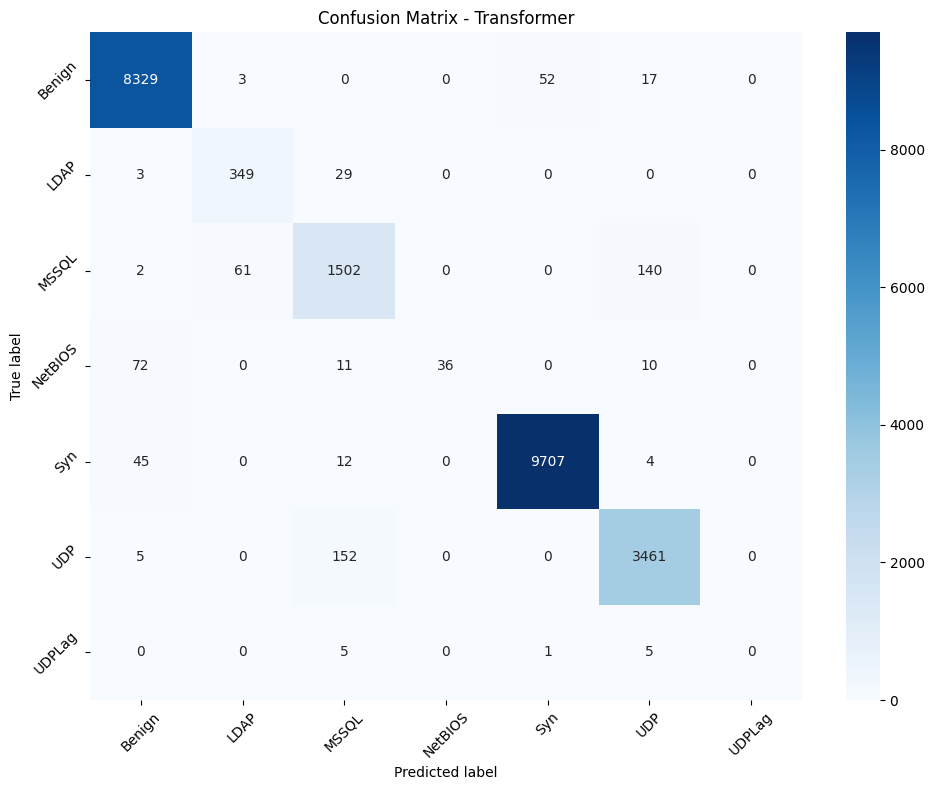

Training Models: 100%|████████████████████████████████████████████████| 3/3 [02:40<00:00, 53.33s/it]


Recall for each class (Transformer):
  Benign: 0.9914
  LDAP: 0.9160
  MSSQL: 0.8809
  NetBIOS: 0.2791
  Syn: 0.9938
  UDP: 0.9566
  UDPLag: 0.0000

--- Final Model Performance Comparison ---


<Figure size 1200x800 with 0 Axes>

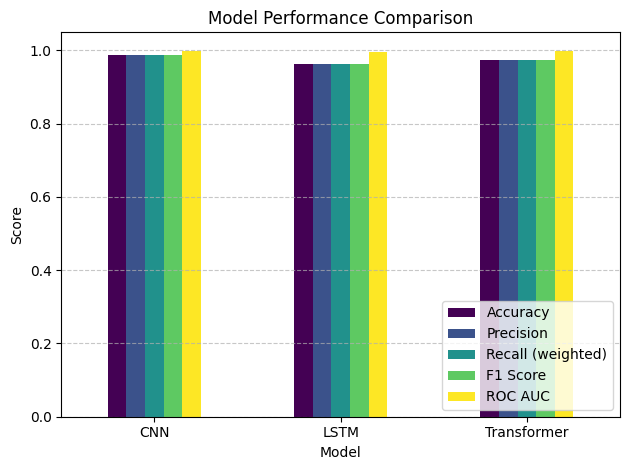


Model Performance Summary:
             Accuracy  Precision  Recall (weighted)  F1 Score   ROC AUC
Model                                                                  
CNN          0.988340   0.988290           0.988340  0.988226  0.999534
LSTM         0.962937   0.963501           0.962937  0.962718  0.996230
Transformer  0.973806   0.973656           0.973806  0.972612  0.997630

--- Learning Curves ---


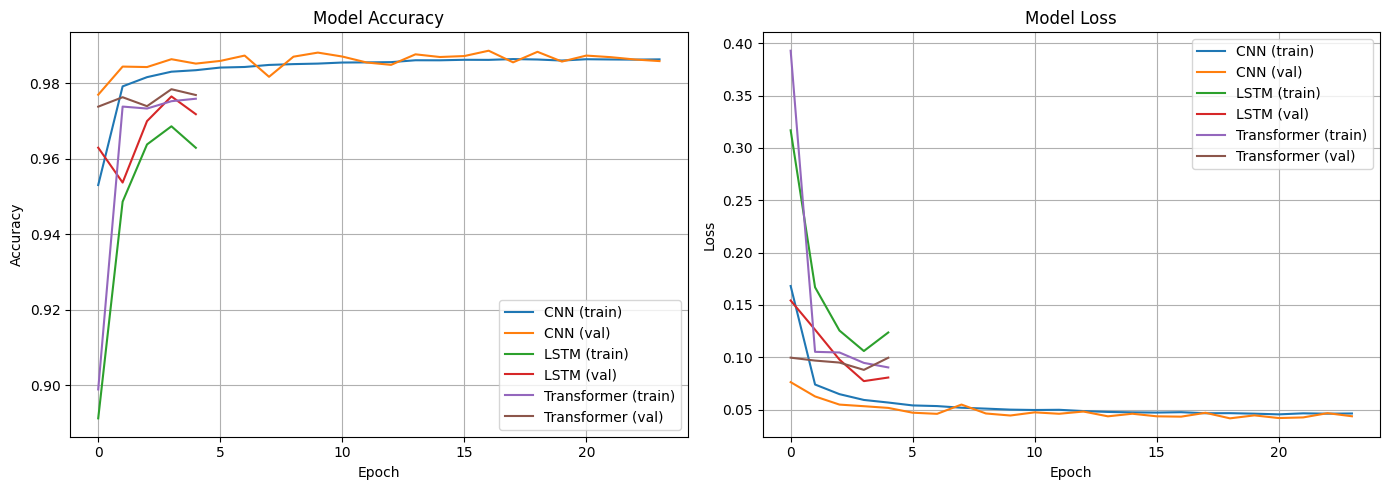


--- Evaluating Models on Test Set ---

Evaluating CNN on test set...
1217/1217 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


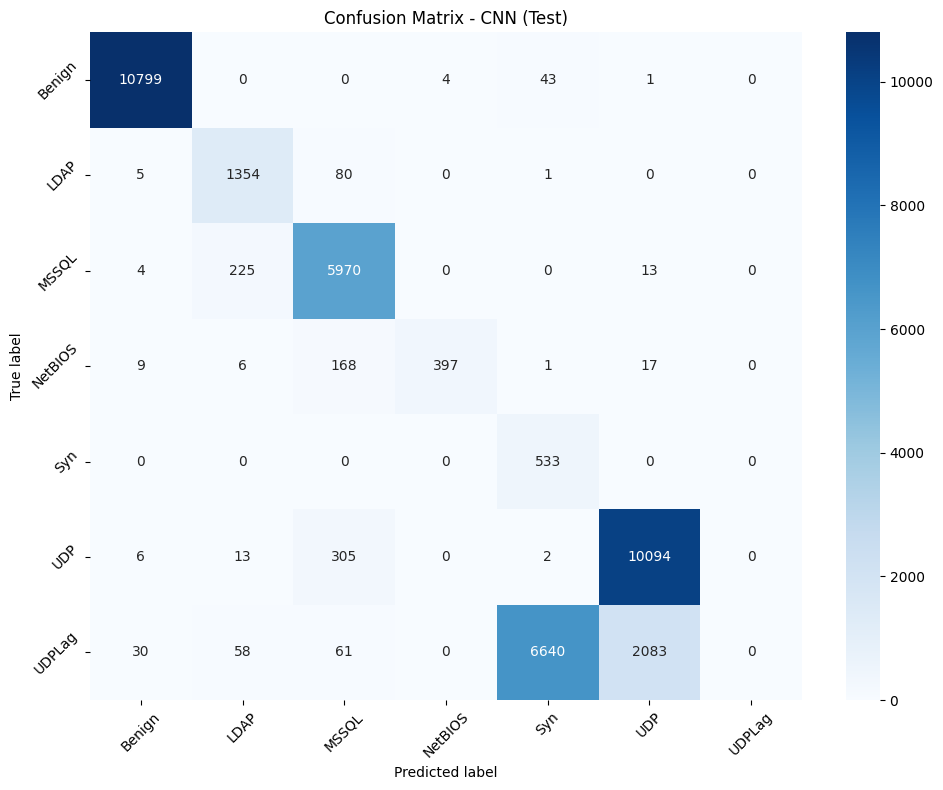


Recall for each class (CNN (Test)):
  Benign: 0.9956
  LDAP: 0.9403
  MSSQL: 0.9610
  NetBIOS: 0.6639
  Syn: 1.0000
  UDP: 0.9687
  UDPLag: 0.0000

Evaluating LSTM on test set...
1217/1217 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


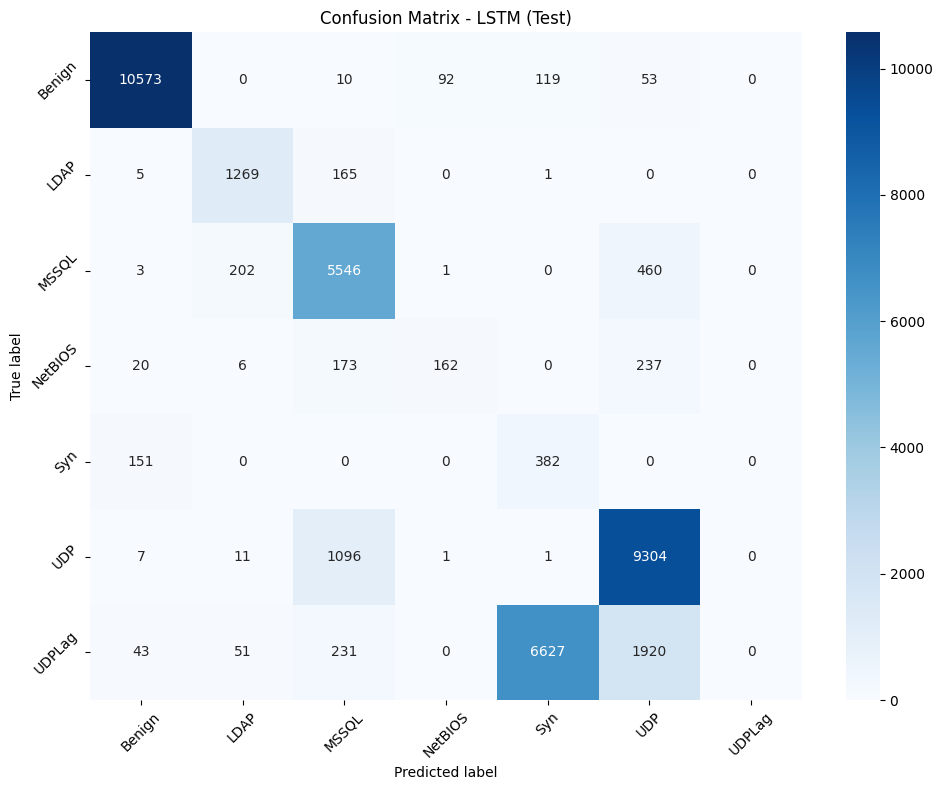


Recall for each class (LSTM (Test)):
  Benign: 0.9747
  LDAP: 0.8812
  MSSQL: 0.8928
  NetBIOS: 0.2709
  Syn: 0.7167
  UDP: 0.8929
  UDPLag: 0.0000

Evaluating Transformer on test set...
1217/1217 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


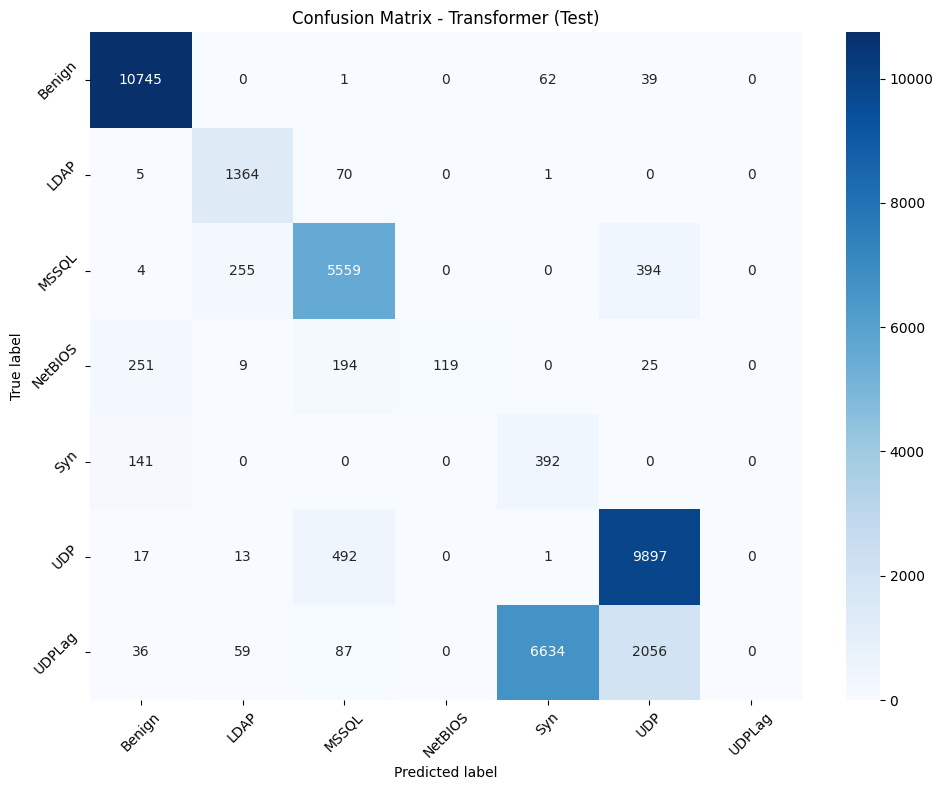


Recall for each class (Transformer (Test)):
  Benign: 0.9906
  LDAP: 0.9472
  MSSQL: 0.8949
  NetBIOS: 0.1990
  Syn: 0.7355
  UDP: 0.9498
  UDPLag: 0.0000

Test Set Results:
                Model  Accuracy  Precision  Recall (weighted)  F1 Score  \
0          CNN (Test)  0.748857   0.689844           0.748857  0.711602   
1         LSTM (Test)  0.699758   0.644339           0.699758  0.665166   
2  Transformer (Test)  0.721340   0.665243           0.721340  0.683073   

    ROC AUC  
0  0.912161  
1  0.840478  
2  0.826589  

--- Feature Importance Analysis ---
3002/3002 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step
3002/3002 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step
3002/3002 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step
3002/3002 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step
3002/3002 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step
3002/3002 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step
3002/3002 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step
3002/3002 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step
3002/3002 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step
3002/3002 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step
3

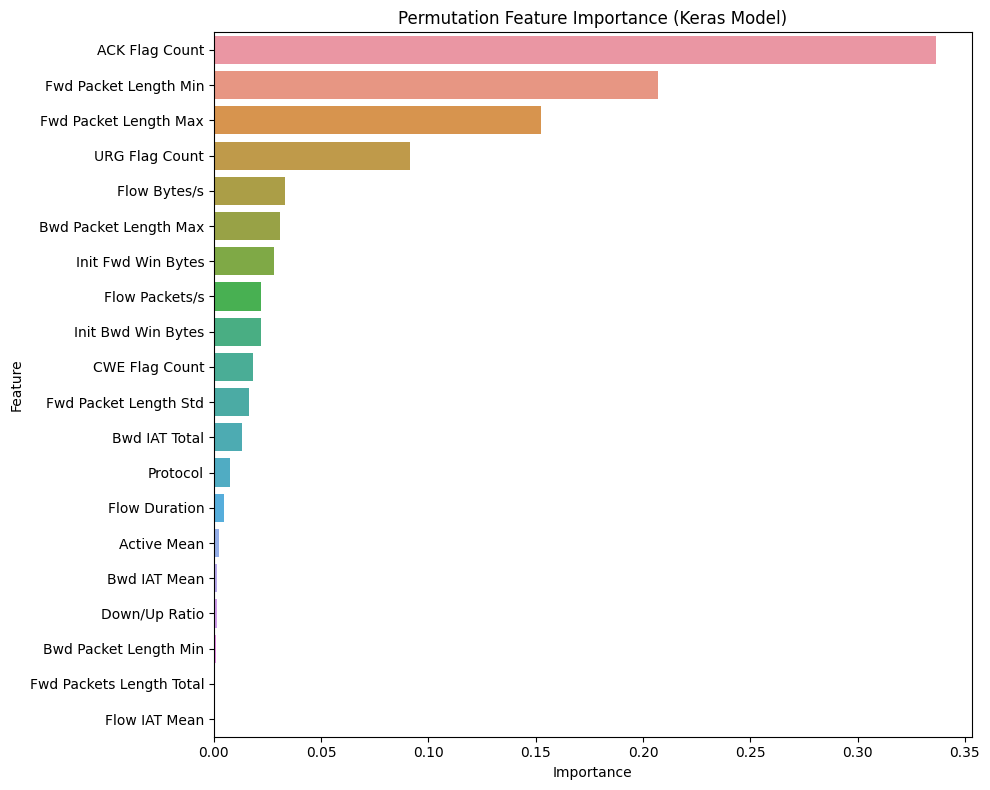


Top 10 Important Features:
                  Feature  Importance
22         ACK Flag Count    0.336378
6   Fwd Packet Length Min    0.206790
5   Fwd Packet Length Max    0.152636
23         URG Flag Count    0.091286
10           Flow Bytes/s    0.033147
8   Bwd Packet Length Max    0.030810
26     Init Fwd Win Bytes    0.028189
11         Flow Packets/s    0.022055
27     Init Bwd Win Bytes    0.022021
24         CWE Flag Count    0.018109

--- Cross-Dataset Evaluation ---

--- Cross-Dataset Evaluation (2019 → 2017) ---
❌ Error during cross-dataset evaluation: y contains previously unseen labels: 'Bruteforce'

--- Saving Final Models ---
✅ Saved H5 model: CNN_ddos_model.h5

--- Project Execution Complete ---


In [32]:
def main():
    print("Starting the DDoS Detection Project...")
    
    # Run K-fold experiments to find best model and threshold
    print("\n--- Running K-fold Cross-Validation ---")
    kfold_results = run_kfold_experiments(
        correlation_thresholds, 
        X_train_reshaped_dict, 
        y_train_dict, 
        n_folds=5, 
        epochs=20, 
        batch_size=64
    )
    
    # Perform statistical test to compare models
    print("\n--- Statistical Analysis of Models ---")
    perform_statistical_test(kfold_results)
    
    # Based on K-fold results, select the best threshold
    # For this example, let's assume 0.85 is the best threshold
    best_threshold = 0.85
    print(f"\n--- Selected best threshold: {best_threshold} ---")
    
    # Train final models on the best threshold
    print("\n--- Training Final Models ---")
    scores_list, history_dict, trained_models = train_deep_models(
        X_train_reshaped_dict[best_threshold],
        X_val_reshaped_dict[best_threshold],
        y_train_cat_dict[best_threshold],
        y_val_cat_dict[best_threshold],
        filtered_dfs[best_threshold],
        test_df,
        epochs=30,
        batch_size=64
    )
    
    # Compare model performance
    print("\n--- Final Model Performance Comparison ---")
    performance_df = compare_model_performance(scores_list)
    print("\nModel Performance Summary:")
    print(performance_df)
    
    # Plot learning curves
    print("\n--- Learning Curves ---")
    plot_learning_curves(history_dict)
    
    # Evaluate on test set
    print("\n--- Evaluating Models on Test Set ---")
    test_results = []
    for name, model in trained_models.items():
        print(f"\nEvaluating {name} on test set...")
        result = evaluate_model(
            model, 
            X_test_reshaped_dict[best_threshold], 
            y_test, 
            y_test_cat, 
            f"{name} (Test)"
        )
        test_results.append(result)
    
    test_results_df = pd.DataFrame(test_results)
    print("\nTest Set Results:")
    print(test_results_df)
    
    # Feature importance for best model
    print("\n--- Feature Importance Analysis ---")
    # Determine the best model based on test set performance
    best_model_name = test_results_df.sort_values('F1 Score', ascending=False).iloc[0]['Model'].split(' ')[0]
    best_model = trained_models[best_model_name]
    
    feature_names = X_train_dict[best_threshold].columns.tolist()
    feature_importance = visualize_feature_importance(
        best_model,
        X_train_scaled_dict[best_threshold],
        feature_names,
        y_train_dict[best_threshold]  # <-- Thêm y_true vào đây
    )
    print("\nTop 10 Important Features:")
    print(feature_importance.head(10))
    
    # Cross-dataset evaluation if data is available
    if has_2017_data:
        print("\n--- Cross-Dataset Evaluation ---")
        cross_eval_df = cross_dataset_evaluation(trained_models, cicddos2017_df)
    
    # Save final models
    print("\n--- Saving Final Models ---")
    best_model.save(f"{best_model_name}_ddos_model.h5")
    print(f"✅ Saved H5 model: {best_model_name}_ddos_model.h5")
    
    print("\n--- Project Execution Complete ---")

# Execute main function if this script is run directly
if __name__ == "__main__":
    main()

### Conclusion

Through this project, I evaluated several machine learning models for DDoS attack detection, aiming to identify the most effective model for classifying various types of DDoS attacks. The results provide insights into the performance of each model, and can help in building more robust cybersecurity systems that are capable of detecting and defending against DDoS attacks in real-world networks.

For more information about the dataset, you can visit the official [CICDDoS2019 Dataset Page](https://www.unb.ca/cic/datasets/ddos-2019.html).